# Trend Following Backtest - With Micro/Mini Contract Support

**Key Feature:** Generate signals from full-size contracts (better data/history), but size positions and calculate P&L using micro/mini specs for better granularity.

**Data paths:**
- Price data: `./02-futures_prices/norgate_continuous/csv/` or `/parquet/`
- Margins: `margin_requirements.csv`

**How it works:**
- `signal_symbol`: Full-size contract used for price data and signal generation
- `trade_symbol`: Micro/mini contract used for position sizing, margin, and P&L
- If no micro exists, signal and trade symbol are the same

In [20]:
import pandas as pd
import numpy as np
import warnings
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass, field
from datetime import datetime
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Optional Norgate for metadata only
try:
    import norgatedata
    NORGATE_AVAILABLE = norgatedata.status()
except:
    NORGATE_AVAILABLE = False

print(f"✓ Imports successful | Norgate metadata: {NORGATE_AVAILABLE}")

✓ Imports successful | Norgate metadata: True


In [21]:
# ==================== CONFIGURATION ====================
CONFIG = {
    'initial_capital': 400000,
    'commission_per_contract': 2.50,
    'fast_period': 50,
    'slow_period': 100,
    'vol_lookback': 60,
    'target_portfolio_vol': 0.20,
    'risk_per_trade': 0.01,
    'target_margin_usage': 0.25,
    'max_leverage': 3.0,
    'start_date': '2015-01-01',
    'end_date': None,
    
    # LOCAL DATA PATHS
    'csv_dir': './02-futures_prices/norgate_continuous/csv',
    'parquet_dir': './02-futures_prices/norgate_continuous/parquet',
    'prefer_parquet': True,
    'margin_file_path': './External_margin_file/margin_requirements.csv',
    'margin_column': 'Overnight Maintenance',
    
    # MICRO/MINI SETTINGS
    'use_micros': True,  # Set to False to use full-size only
}

print("Configuration loaded")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Configuration loaded
  initial_capital: 400000
  commission_per_contract: 2.5
  fast_period: 50
  slow_period: 100
  vol_lookback: 60
  target_portfolio_vol: 0.2
  risk_per_trade: 0.01
  target_margin_usage: 0.25
  max_leverage: 3.0
  start_date: 2015-01-01
  end_date: None
  csv_dir: ./02-futures_prices/norgate_continuous/csv
  parquet_dir: ./02-futures_prices/norgate_continuous/parquet
  prefer_parquet: True
  margin_file_path: ./External_margin_file/margin_requirements.csv
  margin_column: Overnight Maintenance
  use_micros: True


In [22]:
# ==================== MICRO/MINI CONTRACT MAPPING ====================
# Maps full-size signal symbol -> micro/mini trade symbol
# Only includes mappings where the micro/mini EXISTS and is commonly traded

MICRO_MINI_MAPPING = {
    # Equity Indices - Micros available in Norgate
    'ES': 'MES',    # E-mini S&P 500 -> Micro E-mini S&P 500
    'NQ': 'MNQ',    # E-mini Nasdaq -> Micro E-mini Nasdaq
    'RTY': 'M2K',   # E-mini Russell 2000 -> Micro E-mini Russell
    'YM': 'MYM',    # E-mini Dow -> Micro E-mini Dow
    
    # Crypto - Micros available in Norgate
    'BTC': 'MBT',   # Bitcoin -> Micro Bitcoin
    'ETH': 'MET',   # Ether -> Micro Ether
}

# Additional mappings for contracts where micro EXISTS at broker but NOT in Norgate
# These would use full-size data for signals but micro specs for sizing
# You'd trade the micro in live trading
BROKER_ONLY_MICROS = {
    # Currencies - Micros exist at broker, not in Norgate
    '6A': 'M6A',    # Australian Dollar -> Micro AUD
    '6B': 'M6B',    # British Pound -> Micro GBP
    '6C': 'MCD',    # Canadian Dollar -> Micro CAD
    '6E': 'M6E',    # Euro FX -> Micro EUR
    '6J': 'MJY',    # Japanese Yen -> Micro JPY
    '6S': 'MSF',    # Swiss Franc -> Micro CHF
    
    # Energy - Micros exist at broker, not in Norgate
    'CL': 'MCL',    # Crude Oil -> Micro WTI
    'NG': 'MNG',    # Natural Gas -> Micro Henry Hub
    'RB': 'MRB',    # RBOB Gasoline -> Micro RBOB
    'HO': 'MHO',    # Heating Oil -> Micro Heating Oil
    
    # Metals - Micros exist at broker, not in Norgate
    'GC': 'MGC',    # Gold -> Micro Gold
    'SI': 'SIL',    # Silver -> Micro Silver (1000 oz)
    'HG': 'MHG',    # Copper -> Micro Copper
    
    # Agriculture - Micros exist at broker, not in Norgate
    'ZC': 'MZC',    # Corn -> Micro Corn
    'ZW': 'MZW',    # Wheat -> Micro Wheat
    'ZS': 'MZS',    # Soybeans -> Micro Soybeans
    'ZM': 'MZM',    # Soybean Meal -> Micro Soybean Meal
    'ZL': 'MZL',    # Soybean Oil -> Micro Soybean Oil
    
    # Volatility
    'VX': 'VXM',    # VIX -> Mini VIX
}

print(f"✓ Micro mappings defined")
print(f"  Norgate micros: {len(MICRO_MINI_MAPPING)}")
print(f"  Broker-only micros: {len(BROKER_ONLY_MICROS)}")

✓ Micro mappings defined
  Norgate micros: 6
  Broker-only micros: 19


In [23]:
# ==================== TRADE CONTRACT SPECIFICATIONS ====================
# Point values and other specs for TRADE symbols (micros/minis)
# These override the signal symbol specs when sizing positions

TRADE_CONTRACT_SPECS = {
    # Micro Equity Indices (in Norgate)
    'MES': {'point_value': 5, 'tick_size': 0.25, 'tick_value': 1.25},
    'MNQ': {'point_value': 2, 'tick_size': 0.25, 'tick_value': 0.50},
    'M2K': {'point_value': 5, 'tick_size': 0.10, 'tick_value': 0.50},
    'MYM': {'point_value': 0.5, 'tick_size': 1.0, 'tick_value': 0.50},
    
    # Micro Crypto (in Norgate)
    'MBT': {'point_value': 0.1, 'tick_size': 5, 'tick_value': 0.50},
    'MET': {'point_value': 0.1, 'tick_size': 0.05, 'tick_value': 0.005},
    
    # Micro Currencies (broker only) - 1/10th of full-size
    'M6A': {'point_value': 10000, 'tick_size': 0.0001, 'tick_value': 1.00},
    'M6B': {'point_value': 6250, 'tick_size': 0.0001, 'tick_value': 0.625},
    'MCD': {'point_value': 10000, 'tick_size': 0.00005, 'tick_value': 0.50},
    'M6E': {'point_value': 12500, 'tick_size': 0.0001, 'tick_value': 1.25},
    'MJY': {'point_value': 12500, 'tick_size': 0.000001, 'tick_value': 0.0125},
    'MSF': {'point_value': 12500, 'tick_size': 0.0001, 'tick_value': 1.25},
    
    # Micro Energy (broker only) - 1/10th of full-size
    'MCL': {'point_value': 100, 'tick_size': 0.01, 'tick_value': 1.00},
    'MNG': {'point_value': 1000, 'tick_size': 0.001, 'tick_value': 1.00},
    'MRB': {'point_value': 4200, 'tick_size': 0.0001, 'tick_value': 0.42},
    'MHO': {'point_value': 4200, 'tick_size': 0.0001, 'tick_value': 0.42},
    
    # Micro Metals (broker only)
    'MGC': {'point_value': 10, 'tick_size': 0.10, 'tick_value': 1.00},
    'SIL': {'point_value': 1000, 'tick_size': 0.005, 'tick_value': 5.00},
    'MHG': {'point_value': 2500, 'tick_size': 0.0005, 'tick_value': 1.25},
    
    # Micro Agriculture (broker only) - 1/10th of full-size
    'MZC': {'point_value': 5, 'tick_size': 0.125, 'tick_value': 0.625},
    'MZW': {'point_value': 5, 'tick_size': 0.125, 'tick_value': 0.625},
    'MZS': {'point_value': 5, 'tick_size': 0.125, 'tick_value': 0.625},
    'MZM': {'point_value': 10, 'tick_size': 0.10, 'tick_value': 1.00},
    'MZL': {'point_value': 60, 'tick_size': 0.01, 'tick_value': 0.60},
    
    # Mini VIX (broker only) - 1/10th of full-size
    'VXM': {'point_value': 100, 'tick_size': 0.05, 'tick_value': 5.00},
}

print(f"✓ Trade contract specs defined for {len(TRADE_CONTRACT_SPECS)} micro/mini contracts")

✓ Trade contract specs defined for 25 micro/mini contracts


In [24]:
# ==================== DATA CLASSES ====================
@dataclass
class FuturesContract:
    """Futures contract with separate signal and trade specifications"""
    # Identifiers
    signal_symbol: str          # Symbol for price data / signals (e.g., 'ES')
    trade_symbol: str           # Symbol actually traded (e.g., 'MES')
    name: str
    sector: str
    
    # Signal contract specs (for volatility calculation)
    signal_point_value: float
    
    # Trade contract specs (for position sizing and P&L)
    trade_point_value: float
    trade_tick_size: float
    trade_margin: float
    margin_source: str = 'unknown'
    
    # Computed
    granularity_factor: float = field(init=False)
    is_micro: bool = field(init=False)
    
    def __post_init__(self):
        self.granularity_factor = self.signal_point_value / self.trade_point_value if self.trade_point_value > 0 else 1
        self.is_micro = self.signal_symbol != self.trade_symbol

print("✓ Data classes defined")

✓ Data classes defined


In [25]:
# ==================== FULL-SIZE CONTRACT SPECS (for signals) ====================
SIGNAL_CONTRACT_SPECS = {
    # Equity Indices
    'ES': {'point_value': 50, 'sector': 'Stock Index'},
    'NQ': {'point_value': 20, 'sector': 'Stock Index'},
    'RTY': {'point_value': 50, 'sector': 'Stock Index'},
    'YM': {'point_value': 5, 'sector': 'Stock Index'},
    'EMD': {'point_value': 100, 'sector': 'Stock Index'},
    'FESX': {'point_value': 10, 'sector': 'Stock Index'},
    'FDAX': {'point_value': 25, 'sector': 'Stock Index'},
    'NKD': {'point_value': 5, 'sector': 'Stock Index'},
    'NIY': {'point_value': 500, 'sector': 'Stock Index'},
    
    # Interest Rates
    'ZB': {'point_value': 1000, 'sector': 'Interest Rate'},
    'ZN': {'point_value': 1000, 'sector': 'Interest Rate'},
    'ZF': {'point_value': 1000, 'sector': 'Interest Rate'},
    'ZT': {'point_value': 2000, 'sector': 'Interest Rate'},
    'FGBL': {'point_value': 1000, 'sector': 'Interest Rate'},
    'FGBM': {'point_value': 1000, 'sector': 'Interest Rate'},
    'FGBS': {'point_value': 1000, 'sector': 'Interest Rate'},
    
    # Energy
    'CL': {'point_value': 1000, 'sector': 'Energy'},
    'NG': {'point_value': 10000, 'sector': 'Energy'},
    'HO': {'point_value': 42000, 'sector': 'Energy'},
    'RB': {'point_value': 42000, 'sector': 'Energy'},
    'BRN': {'point_value': 1000, 'sector': 'Energy'},
    
    # Metals
    'GC': {'point_value': 100, 'sector': 'Metals'},
    'SI': {'point_value': 5000, 'sector': 'Metals'},
    'HG': {'point_value': 25000, 'sector': 'Metals'},
    'PL': {'point_value': 50, 'sector': 'Metals'},
    'PA': {'point_value': 100, 'sector': 'Metals'},
    
    # Agriculture
    'ZC': {'point_value': 50, 'sector': 'Agriculture'},
    'ZS': {'point_value': 50, 'sector': 'Agriculture'},
    'ZW': {'point_value': 50, 'sector': 'Agriculture'},
    'ZM': {'point_value': 100, 'sector': 'Agriculture'},
    'ZL': {'point_value': 600, 'sector': 'Agriculture'},
    'CT': {'point_value': 500, 'sector': 'Agriculture'},
    'KC': {'point_value': 375, 'sector': 'Agriculture'},
    'SB': {'point_value': 1120, 'sector': 'Agriculture'},
    'CC': {'point_value': 10, 'sector': 'Agriculture'},
    
    # Currencies
    '6E': {'point_value': 125000, 'sector': 'Currency'},
    '6J': {'point_value': 125000, 'sector': 'Currency'},
    '6B': {'point_value': 62500, 'sector': 'Currency'},
    '6A': {'point_value': 100000, 'sector': 'Currency'},
    '6C': {'point_value': 100000, 'sector': 'Currency'},
    '6S': {'point_value': 125000, 'sector': 'Currency'},
    'DX': {'point_value': 1000, 'sector': 'Currency'},
    
    # Crypto
    'BTC': {'point_value': 5, 'sector': 'Crypto'},
    'ETH': {'point_value': 50, 'sector': 'Crypto'},
    
    # Volatility
    'VX': {'point_value': 1000, 'sector': 'Volatility'},
}

print(f"✓ Signal contract specs defined for {len(SIGNAL_CONTRACT_SPECS)} contracts")

✓ Signal contract specs defined for 45 contracts


In [26]:
# ==================== LOCAL DATA LOADING ====================
def load_local_price_data(symbol: str) -> Optional[pd.DataFrame]:
    """Load price data from local CSV/Parquet files."""
    clean_symbol = symbol.strip().upper().lstrip('&')
    
    if CONFIG['prefer_parquet']:
        paths = [
            (CONFIG['parquet_dir'], f"{clean_symbol}.parquet", 'parquet'),
            (CONFIG['csv_dir'], f"{clean_symbol}.csv", 'csv'),
        ]
    else:
        paths = [
            (CONFIG['csv_dir'], f"{clean_symbol}.csv", 'csv'),
            (CONFIG['parquet_dir'], f"{clean_symbol}.parquet", 'parquet'),
        ]
    
    for directory, filename, fmt in paths:
        filepath = Path(directory) / filename
        if filepath.exists():
            try:
                if fmt == 'parquet':
                    df = pd.read_parquet(filepath)
                else:
                    df = pd.read_csv(filepath)
                return _standardize_df(df)
            except Exception as e:
                continue
    return None

def _standardize_df(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names: lowercase -> Title Case"""
    if 'date' in df.columns:
        df = df.set_index('date')
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    
    col_map = {'open': 'Open', 'high': 'High', 'low': 'Low', 
               'close': 'Close', 'volume': 'Volume', 'settle': 'Close'}
    df.columns = [col_map.get(c.lower().strip(), c) for c in df.columns]
    return df

def get_available_symbols() -> List[str]:
    """Get symbols with local data."""
    symbols = set()
    for d in [CONFIG['csv_dir'], CONFIG['parquet_dir']]:
        p = Path(d)
        if p.exists():
            for f in p.glob('*.*'):
                if f.suffix in ['.csv', '.parquet']:
                    symbols.add(f.stem.upper())
    return sorted(symbols)

# Test
available = get_available_symbols()
print(f"✓ Found {len(available)} symbols with local data")
if available:
    print(f"  First 10: {available[:10]}")

✓ Found 105 symbols with local data
  First 10: ['6A', '6B', '6C', '6E', '6J', '6M', '6N', '6S', 'AFB', 'AWM']


In [27]:
# ==================== MARGIN LOADING ====================
def load_margin_lookup() -> Dict:
    """Load margin requirements from CSV - indexed by Trading Class."""
    try:
        df = pd.read_csv(CONFIG['margin_file_path'])
        print(f"✓ Loaded {len(df)} margin records")
    except FileNotFoundError:
        print(f"⚠ Margin file not found")
        return {}
    
    lookup = {}
    if 'Currency' in df.columns:
        df = df.sort_values(by='Currency', key=lambda x: x != 'USD')
    
    for _, row in df.iterrows():
        sym = str(row.get('Trading Class', '')).strip().upper()
        if not sym or sym in lookup:
            continue
        try:
            margin = float(row[CONFIG['margin_column']])
            if pd.notna(margin) and margin > 0:
                lookup[sym] = margin
        except:
            continue
    print(f"✓ {len(lookup)} unique margin entries")
    return lookup

margin_lookup = load_margin_lookup()

✓ Loaded 355 margin records
✓ 349 unique margin entries


In [28]:
# ==================== BUILD INSTRUMENT UNIVERSE ====================
def get_trade_symbol(signal_symbol: str, use_micros: bool = True) -> str:
    """Get the trade symbol for a given signal symbol."""
    if not use_micros:
        return signal_symbol
    
    # Check Norgate micros first (we have data for these)
    if signal_symbol in MICRO_MINI_MAPPING:
        return MICRO_MINI_MAPPING[signal_symbol]
    
    # Check broker-only micros (we use full-size data but micro specs)
    if signal_symbol in BROKER_ONLY_MICROS:
        return BROKER_ONLY_MICROS[signal_symbol]
    
    return signal_symbol


def get_margin_for_symbol(symbol: str, margin_lookup: Dict) -> Tuple[float, str]:
    """Get margin for symbol from lookup."""
    if symbol in margin_lookup:
        return margin_lookup[symbol], 'spreadsheet'
    
    # Try Norgate if available
    if NORGATE_AVAILABLE:
        try:
            m = norgatedata.margin(f"&{symbol}")
            if m and m > 0:
                return m, 'norgate'
        except:
            pass
    
    return 5000, 'default'


def build_universe(signal_symbols: List[str], 
                   use_micros: bool = True,
                   max_margin: float = None) -> List[FuturesContract]:
    """
    Build instrument universe with signal/trade symbol mapping.
    
    Parameters:
    -----------
    signal_symbols : List[str]
        List of full-size symbols to use for signals
    use_micros : bool
        If True, use micro/mini contracts for trading where available
    max_margin : float
        Maximum margin per contract (filters out expensive contracts)
    """
    available_data = set(get_available_symbols())
    instruments = []
    skipped = []
    
    print(f"Building universe from {len(signal_symbols)} signal symbols...")
    print(f"Use micros: {use_micros}")
    print("=" * 70)
    
    for signal_sym in signal_symbols:
        signal_sym = signal_sym.strip().upper()
        
        # Check we have data for the signal symbol
        if signal_sym not in available_data:
            skipped.append(f"{signal_sym} (no signal data)")
            continue
        
        # Get trade symbol
        trade_sym = get_trade_symbol(signal_sym, use_micros)
        
        # Get signal specs
        if signal_sym in SIGNAL_CONTRACT_SPECS:
            signal_specs = SIGNAL_CONTRACT_SPECS[signal_sym]
        elif NORGATE_AVAILABLE:
            try:
                pv = norgatedata.point_value(f"&{signal_sym}")
                sector = norgatedata.classification(f"&{signal_sym}", 
                    'NorgateDataFuturesClassification', 'Name') or 'Unknown'
                signal_specs = {'point_value': pv or 1000, 'sector': sector}
            except:
                signal_specs = {'point_value': 1000, 'sector': 'Unknown'}
        else:
            skipped.append(f"{signal_sym} (no specs)")
            continue
        
        # Get trade specs
        if trade_sym in TRADE_CONTRACT_SPECS:
            trade_pv = TRADE_CONTRACT_SPECS[trade_sym]['point_value']
            trade_tick = TRADE_CONTRACT_SPECS[trade_sym]['tick_size']
        else:
            # Same as signal (full-size)
            trade_pv = signal_specs['point_value']
            trade_tick = 0.01
        
        # Get margin for TRADE symbol
        margin, margin_src = get_margin_for_symbol(trade_sym, margin_lookup)
        
        # Filter by max margin
        if max_margin and margin > max_margin:
            skipped.append(f"{signal_sym} (margin ${margin:,.0f})")
            continue
        
        # Get name
        if NORGATE_AVAILABLE:
            try:
                name = norgatedata.futures_market_name(signal_sym) or signal_sym
            except:
                name = signal_sym
        else:
            name = signal_sym
        
        instruments.append(FuturesContract(
            signal_symbol=signal_sym,
            trade_symbol=trade_sym,
            name=name,
            sector=signal_specs['sector'],
            signal_point_value=signal_specs['point_value'],
            trade_point_value=trade_pv,
            trade_tick_size=trade_tick,
            trade_margin=margin,
            margin_source=margin_src,
        ))
    
    print(f"\n✓ Built universe with {len(instruments)} instruments")
    micros = sum(1 for i in instruments if i.is_micro)
    print(f"  Using micros/minis: {micros}")
    print(f"  Using full-size: {len(instruments) - micros}")
    
    if skipped:
        print(f"\n⚠ Skipped {len(skipped)}:")
        for s in skipped[:10]:
            print(f"   - {s}")
        if len(skipped) > 10:
            print(f"   ... and {len(skipped) - 10} more")
    
    return instruments

In [29]:
# ==================== SELECTED SYMBOLS ====================
SELECTED_SIGNALS = [
    # Equity Indices
    'ES', 'NQ', 'RTY', 'YM', 'EMD',
    'FESX', 'NKD',
    
    # Interest Rates
    'ZB', 'ZN', 'ZF', 'ZT',
    'FGBL', 'FGBM', 'FGBS',
    
    # Energy
    'CL', 'NG', 'RB', 'BRN',
    
    # Metals
    'GC', 'HG', 'PL',
    
    # Agriculture
    'ZC', 'ZS', 'ZW', 'ZM', 'ZL',
    'CT', 'SB', 'CC',
    
    # Currencies
    '6E', '6J', '6B', '6A', '6C', '6S', 'DX',
    
    # Volatility
    'VX',
]

# Build universe
instruments = build_universe(
    SELECTED_SIGNALS,
    use_micros=CONFIG['use_micros'],
    max_margin=CONFIG['initial_capital'] * 0.05
)

Building universe from 37 signal symbols...
Use micros: True

✓ Built universe with 36 instruments
  Using micros/minis: 21
  Using full-size: 15

⚠ Skipped 1:
   - EMD (margin $23,038)


In [30]:
# ==================== DISPLAY UNIVERSE WITH MAPPING ====================
print("\n" + "=" * 100)
print("INSTRUMENT UNIVERSE - SIGNAL/TRADE MAPPING")
print("=" * 100)
print(f"{'Signal':<8} {'Trade':<8} {'Name':<25} {'Sector':<15} {'Sig PV':>10} {'Trade PV':>10} {'Margin':>10} {'Granul':>8}")
print("-" * 100)

for inst in sorted(instruments, key=lambda x: (x.sector, x.signal_symbol)):
    micro_flag = "*" if inst.is_micro else " "
    print(f"{inst.signal_symbol:<8} {inst.trade_symbol:<7}{micro_flag} {inst.name[:24]:<25} {inst.sector:<15} "
          f"${inst.signal_point_value:>8,.0f} ${inst.trade_point_value:>8,.1f} ${inst.trade_margin:>8,.0f} "
          f"{inst.granularity_factor:>7.1f}x")

print("-" * 100)
print("* = Using micro/mini for trading")
print(f"\nGranularity factor = Signal PV / Trade PV (higher = finer position sizing)")


INSTRUMENT UNIVERSE - SIGNAL/TRADE MAPPING
Signal   Trade    Name                      Sector              Sig PV   Trade PV     Margin   Granul
----------------------------------------------------------------------------------------------------
CC       CC       Cocoa                     Agriculture     $      10 $    10.0 $   9,736     1.0x
CT       CT       Cotton No. 2              Agriculture     $     500 $   500.0 $   1,467     1.0x
SB       SB       Sugar No. 11              Agriculture     $   1,120 $ 1,120.0 $   1,451     1.0x
ZC       MZC    * Corn                      Agriculture     $      50 $     5.0 $     142    10.0x
ZL       MZL    * Soybean Oil               Agriculture     $     600 $    60.0 $     292    10.0x
ZM       MZM    * Soybean Meal              Agriculture     $     100 $    10.0 $     244    10.0x
ZS       MZS    * Soybean                   Agriculture     $      50 $     5.0 $     322    10.0x
ZW       MZW    * Chicago SRW Wheat         Agriculture     

In [31]:
# ==================== STRATEGY CLASSES ====================
class TrendFollowingStrategy:
    def __init__(self, fast=50, slow=100, vol_lb=60):
        self.fast_period, self.slow_period, self.vol_lookback = fast, slow, vol_lb
    
    def calculate_signals(self, prices: pd.Series) -> pd.Series:
        fast = prices.rolling(self.fast_period).mean()
        slow = prices.rolling(self.slow_period).mean()
        sig = pd.Series(0, index=prices.index)
        sig[fast > slow] = 1
        sig[fast < slow] = -1
        return sig
    
    def calculate_volatility(self, prices: pd.Series) -> pd.Series:
        return prices.pct_change().rolling(self.vol_lookback).std() * np.sqrt(252)


class PositionSizer:
    def __init__(self, account, target_vol=0.20, risk=0.01, max_lev=3.0):
        self.account_size = account
        self.risk_per_trade = risk
        self.max_leverage = max_lev
    
    def calculate_position_size(self, signal, inst: FuturesContract, price, vol, _) -> int:
        """
        Calculate position size using TRADE contract specs.
        
        Note: volatility is calculated from signal prices, but we size
        using trade_point_value for the actual contracts we'll hold.
        """
        if signal == 0 or np.isnan(vol) or vol == 0:
            return 0
        
        # Dollar volatility per TRADE contract
        dollar_vol = price * inst.trade_point_value * vol
        
        # Position size based on risk
        risk_capital = self.account_size * self.risk_per_trade
        contracts = int(np.sign(signal) * risk_capital / dollar_vol)
        
        # Leverage limit using trade specs
        notional = abs(contracts) * price * inst.trade_point_value
        if notional > self.account_size * self.max_leverage:
            contracts = int(np.sign(contracts) * self.account_size * self.max_leverage / 
                          (price * inst.trade_point_value))
        
        return contracts


class PortfolioManager:
    def __init__(self, account, target_margin=0.25):
        self.account_size = account
        self.target_margin_usage = target_margin
    
    def update_positions(self, positions: Dict[str, Tuple[int, FuturesContract]]):
        """Apply margin constraints using TRADE margin."""
        total_margin = sum(abs(c) * inst.trade_margin for c, inst in positions.values())
        max_margin = self.account_size * self.target_margin_usage
        
        if total_margin > max_margin:
            scale = max_margin / total_margin
            return {s: (int(c * scale), inst) for s, (c, inst) in positions.items()}
        return positions
    
    def get_portfolio_statistics(self, positions: Dict[str, Tuple[int, FuturesContract, float]]) -> Dict:
        total_margin = sum(abs(c) * inst.trade_margin for c, inst, _ in positions.values())
        return {
            'margin_utilization': total_margin / self.account_size if self.account_size > 0 else 0,
            'num_positions': len([c for c, _, _ in positions.values() if c != 0])
        }

print("✓ Strategy classes defined")

✓ Strategy classes defined


In [32]:
# ==================== BACKTEST ENGINE ====================
class MicroAwareBacktestEngine:
    """
    Backtesting engine that uses signal symbols for price data/signals
    but trade symbols for position sizing and P&L.
    """
    
    def __init__(self, instruments: List[FuturesContract],
                 account=400000, fast=50, slow=100,
                 target_vol=0.20, risk=0.01, target_margin=0.25, commission=2.50):
        
        self.initial_capital = account
        self.commission = commission
        self.strategy = TrendFollowingStrategy(fast, slow)
        self.position_sizer = PositionSizer(account, target_vol, risk)
        self.portfolio_manager = PortfolioManager(account, target_margin)
        
        # Index by SIGNAL symbol (since that's what we use for price data)
        self.instruments = {inst.signal_symbol: inst for inst in instruments}
    
    def load_data(self, start, end=None) -> Dict[str, pd.DataFrame]:
        """Load price data using SIGNAL symbols."""
        print(f"Loading data ({start} to {end or 'latest'})...")
        start_dt = pd.Timestamp(start)
        end_dt = pd.Timestamp(end) if end else None
        
        data = {}
        for signal_sym, inst in self.instruments.items():
            df = load_local_price_data(signal_sym)  # Load SIGNAL symbol data
            if df is not None:
                df = df[df.index >= start_dt]
                if end_dt:
                    df = df[df.index <= end_dt]
                if len(df) > 0:
                    data[signal_sym] = df
                    trade_note = f" -> trade {inst.trade_symbol}" if inst.is_micro else ""
                    print(f"  {signal_sym}: {len(df)} records{trade_note}")
        
        print(f"✓ Loaded {len(data)}/{len(self.instruments)} instruments")
        return data
    
    def run_backtest(self, price_data: Dict[str, pd.DataFrame]) -> pd.DataFrame:
        """Run backtest using signal data but trade specs."""
        # Common dates
        all_dates = None
        for df in price_data.values():
            all_dates = set(df.index) if all_dates is None else all_dates & set(df.index)
        dates = sorted(all_dates)
        
        print(f"Backtest: {dates[0].date()} to {dates[-1].date()} ({len(dates)} days)")
        
        positions = {s: 0 for s in self.instruments}
        equity = self.initial_capital
        results = []
        
        for i, date in enumerate(dates):
            if i < self.strategy.slow_period:
                results.append({'date': date, 'equity': equity, 'daily_return': 0,
                               'num_positions': 0, 'margin_usage': 0})
                continue
            
            new_pos = {}
            for signal_sym, inst in self.instruments.items():
                if signal_sym not in price_data or date not in price_data[signal_sym].index:
                    continue
                
                df = price_data[signal_sym]
                hist = df.loc[df.index <= date, 'Close']
                price = hist.iloc[-1]
                
                # Signal from full-size data
                sig = self.strategy.calculate_signals(hist).iloc[-1]
                vol = self.strategy.calculate_volatility(hist).iloc[-1]
                
                # Size using TRADE specs (micro/mini)
                contracts = self.position_sizer.calculate_position_size(
                    sig, inst, price, vol, positions)
                
                new_pos[signal_sym] = (contracts, inst, price)
            
            # Apply margin constraints using TRADE margin
            managed = self.portfolio_manager.update_positions(
                {s: (c, inst) for s, (c, inst, _) in new_pos.items()})
            
            # Calculate P&L using TRADE point value
            daily_pnl = 0
            comm = 0
            
            for signal_sym in self.instruments:
                if signal_sym in managed and signal_sym in price_data:
                    if date in price_data[signal_sym].index:
                        new_c = managed[signal_sym][0]
                        old_c = positions[signal_sym]
                        if abs(new_c - old_c) > 0:
                            comm += abs(new_c - old_c) * self.commission
            
            if i > 0:
                prev = dates[i-1]
                for signal_sym, c in positions.items():
                    if c != 0 and signal_sym in price_data:
                        df = price_data[signal_sym]
                        if date in df.index and prev in df.index:
                            price_change = df.loc[date, 'Close'] - df.loc[prev, 'Close']
                            inst = self.instruments[signal_sym]
                            # P&L uses TRADE point value
                            daily_pnl += c * price_change * inst.trade_point_value
            
            equity += daily_pnl - comm
            
            # Update positions
            for s, (c, _) in managed.items():
                positions[s] = c
            
            pos_data = {s: (positions[s], self.instruments[s], 
                           new_pos.get(s, (0, None, 0))[2])
                       for s in positions}
            stats = self.portfolio_manager.get_portfolio_statistics(pos_data)
            
            results.append({
                'date': date, 
                'equity': equity,
                'daily_return': (daily_pnl - comm) / (equity - daily_pnl + comm) if equity > 0 else 0,
                'num_positions': stats['num_positions'],
                'margin_usage': stats['margin_utilization']
            })
            
            self.position_sizer.account_size = equity
            self.portfolio_manager.account_size = equity
            
            if i % 500 == 0:
                print(f"  Day {i}/{len(dates)}...")
        
        return pd.DataFrame(results).set_index('date')
    
    def calculate_metrics(self, results: pd.DataFrame) -> Dict:
        ret = results['daily_return']
        eq = results['equity']
        
        total_ret = (eq.iloc[-1] - self.initial_capital) / self.initial_capital
        years = len(ret) / 252
        ann_ret = (1 + total_ret) ** (1 / years) - 1 if years > 0 else 0
        ann_vol = ret.std() * np.sqrt(252)
        sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
        
        cum = (1 + ret).cumprod()
        dd = (cum - cum.expanding().max()) / cum.expanding().max()
        max_dd = dd.min()
        calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
        
        wins = (ret > 0).sum()
        losses = (ret < 0).sum()
        
        return {
            'Total Return (%)': total_ret * 100,
            'Ann Return (%)': ann_ret * 100,
            'Ann Vol (%)': ann_vol * 100,
            'Sharpe': sharpe,
            'Max DD (%)': max_dd * 100,
            'Calmar': calmar,
            'Win Rate (%)': wins / (wins + losses) * 100 if (wins + losses) > 0 else 0,
            'Final Equity': eq.iloc[-1],
            'Avg Margin (%)': results['margin_usage'].mean() * 100,
        }

print("✓ MicroAwareBacktestEngine defined")

✓ MicroAwareBacktestEngine defined


In [33]:
# ==================== RUN BACKTEST ====================
engine = MicroAwareBacktestEngine(
    instruments=instruments,
    account=CONFIG['initial_capital'],
    fast=CONFIG['fast_period'],
    slow=CONFIG['slow_period'],
    target_vol=CONFIG['target_portfolio_vol'],
    risk=CONFIG['risk_per_trade'],
    target_margin=CONFIG['target_margin_usage'],
    commission=CONFIG['commission_per_contract']
)

price_data = engine.load_data(CONFIG['start_date'], CONFIG['end_date'])

Loading data (2015-01-01 to latest)...
  ES: 502 records -> trade MES
  NQ: 502 records -> trade MNQ
  RTY: 502 records -> trade M2K
  YM: 502 records -> trade MYM
  FESX: 506 records
  NKD: 502 records
  ZB: 502 records
  ZN: 502 records
  ZF: 502 records
  ZT: 502 records
  FGBL: 506 records
  FGBM: 506 records
  FGBS: 506 records
  CL: 502 records -> trade MCL
  NG: 502 records -> trade MNG
  RB: 502 records -> trade MRB
  BRN: 516 records
  GC: 502 records -> trade MGC
  HG: 502 records -> trade MHG
  PL: 502 records
  ZC: 502 records -> trade MZC
  ZS: 502 records -> trade MZS
  ZW: 502 records -> trade MZW
  ZM: 502 records -> trade MZM
  ZL: 502 records -> trade MZL
  CT: 502 records
  SB: 502 records
  CC: 502 records
  6E: 502 records -> trade M6E
  6J: 502 records -> trade MJY
  6B: 502 records -> trade M6B
  6A: 502 records -> trade M6A
  6C: 502 records -> trade MCD
  6S: 502 records -> trade MSF
  DX: 516 records
  VX: 502 records -> trade VXM
✓ Loaded 36/36 instruments


In [34]:
print("\nRunning backtest...")
results = engine.run_backtest(price_data)
metrics = engine.calculate_metrics(results)
print(f"\n✓ Complete! Final equity: ${metrics['Final Equity']:,.2f}")


Running backtest...
Backtest: 2024-01-22 to 2026-01-20 (492 days)

✓ Complete! Final equity: $382,082.77


In [35]:
# ==================== PERFORMANCE REPORT ====================
print("=" * 60)
print("PERFORMANCE METRICS")
print("=" * 60)
for k, v in metrics.items():
    if 'Equity' in k:
        print(f"  {k:20} ${v:>15,.2f}")
    elif '%' in k:
        print(f"  {k:20} {v:>15.2f}%")
    else:
        print(f"  {k:20} {v:>15.3f}")

PERFORMANCE METRICS
  Total Return (%)               -4.48%
  Ann Return (%)                 -2.32%
  Ann Vol (%)                     4.83%
  Sharpe                        -0.480
  Max DD (%)                     -6.86%
  Calmar                        -0.338
  Win Rate (%)                   47.45%
  Final Equity         $     382,082.77
  Avg Margin (%)                  5.51%


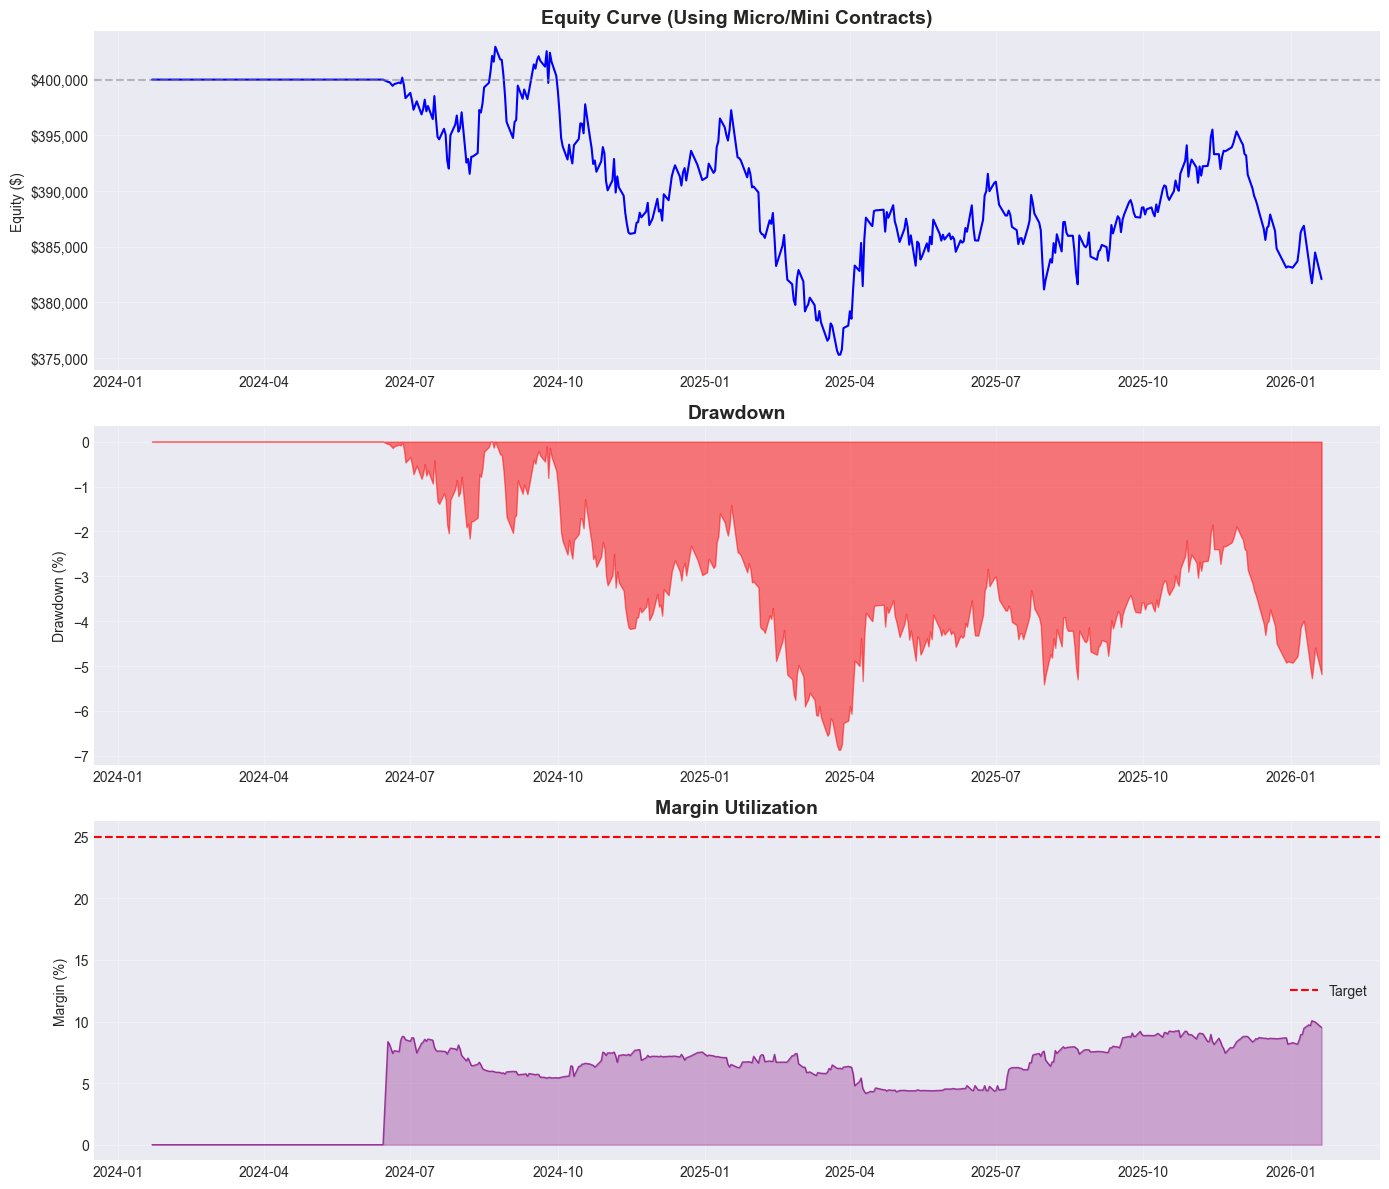

✓ Charts saved to backtest_results_micros.png


In [36]:
# ==================== VISUALIZATION ====================
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Equity curve
ax1 = axes[0]
ax1.plot(results.index, results['equity'], linewidth=1.5, color='blue')
ax1.axhline(CONFIG['initial_capital'], color='gray', linestyle='--', alpha=0.5)
ax1.set_title('Equity Curve (Using Micro/Mini Contracts)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Equity ($)')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax1.grid(True, alpha=0.3)

# Drawdown
ax2 = axes[1]
cum = (1 + results['daily_return']).cumprod()
dd = (cum - cum.expanding().max()) / cum.expanding().max() * 100
ax2.fill_between(results.index, 0, dd, alpha=0.5, color='red')
ax2.set_title('Drawdown', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown (%)')
ax2.grid(True, alpha=0.3)

# Margin
ax3 = axes[2]
ax3.plot(results.index, results['margin_usage'] * 100, linewidth=1, color='purple', alpha=0.7)
ax3.axhline(CONFIG['target_margin_usage'] * 100, color='red', linestyle='--', label='Target')
ax3.fill_between(results.index, 0, results['margin_usage'] * 100, alpha=0.3, color='purple')
ax3.set_title('Margin Utilization', fontsize=14, fontweight='bold')
ax3.set_ylabel('Margin (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('backtest_results_micros.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Charts saved to backtest_results_micros.png")

In [37]:
# ==================== POSITION SIZE COMPARISON ====================
# Show how position sizes differ between full-size and micro

print("\n" + "=" * 80)
print("POSITION SIZE GRANULARITY COMPARISON")
print("=" * 80)
print(f"Account: ${CONFIG['initial_capital']:,} | Risk per trade: {CONFIG['risk_per_trade']*100}%")
print("-" * 80)
print(f"{'Signal':<8} {'Trade':<8} {'Price':>10} {'Vol':>8} {'Full-Size':>12} {'Micro':>12} {'Improvement':>12}")
print("-" * 80)

# Get latest prices and calculate example positions
risk_capital = CONFIG['initial_capital'] * CONFIG['risk_per_trade']

for signal_sym, inst in sorted(engine.instruments.items()):
    if signal_sym in price_data and len(price_data[signal_sym]) > 60:
        df = price_data[signal_sym]
        price = df['Close'].iloc[-1]
        vol = df['Close'].pct_change().rolling(60).std().iloc[-1] * np.sqrt(252)
        
        if np.isnan(vol) or vol == 0:
            continue
        
        # Full-size position
        full_dollar_vol = price * inst.signal_point_value * vol
        full_contracts = risk_capital / full_dollar_vol
        
        # Micro position
        micro_dollar_vol = price * inst.trade_point_value * vol
        micro_contracts = risk_capital / micro_dollar_vol
        
        improvement = micro_contracts / full_contracts if full_contracts > 0 else 0
        
        print(f"{signal_sym:<8} {inst.trade_symbol:<8} ${price:>9,.2f} {vol:>7.1%} "
              f"{full_contracts:>11.1f} {micro_contracts:>11.1f} {improvement:>11.1f}x")

print("-" * 80)
print("Improvement = how many more contracts you can fine-tune with using micros")


POSITION SIZE GRANULARITY COMPARISON
Account: $400,000 | Risk per trade: 1.0%
--------------------------------------------------------------------------------
Signal   Trade         Price      Vol    Full-Size        Micro  Improvement
--------------------------------------------------------------------------------
6A       M6A      $     0.67    6.1%         1.0         9.7        10.0x
6B       M6B      $     1.34    5.8%         0.8         8.3        10.0x
6C       MCD      $     0.72    4.4%         1.3        12.6        10.0x
6E       M6E      $     1.17    4.4%         0.6         6.1        10.0x
6J       MJY      $     0.63    7.1%         0.7         7.1        10.0x
6S       MSF      $     1.27    6.7%         0.4         3.8        10.0x
BRN      BRN      $    64.92   24.6%         0.3         0.3         1.0x
CC       CC       $ 4,648.00   54.0%         0.2         0.2         1.0x
CL       MCL      $    60.36   28.2%         0.2         2.4        10.0x
CT       CT     

In [38]:
# ==================== SAVE RESULTS ====================
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

results.to_csv(f"backtest_results_micros_{timestamp}.csv")
print(f"✓ Results saved: backtest_results_micros_{timestamp}.csv")

with open(f"metrics_micros_{timestamp}.json", 'w') as f:
    json.dump({k: float(v) if isinstance(v, (np.floating, np.integer)) else v 
               for k, v in metrics.items()}, f, indent=2)
print(f"✓ Metrics saved: metrics_micros_{timestamp}.json")

# Save instrument mapping
mapping_data = []
for inst in instruments:
    mapping_data.append({
        'signal_symbol': inst.signal_symbol,
        'trade_symbol': inst.trade_symbol,
        'name': inst.name,
        'sector': inst.sector,
        'signal_point_value': inst.signal_point_value,
        'trade_point_value': inst.trade_point_value,
        'trade_margin': inst.trade_margin,
        'granularity_factor': inst.granularity_factor,
        'is_micro': inst.is_micro,
    })

pd.DataFrame(mapping_data).to_csv(f"instrument_mapping_{timestamp}.csv", index=False)
print(f"✓ Mapping saved: instrument_mapping_{timestamp}.csv")

✓ Results saved: backtest_results_micros_20260121_181729.csv
✓ Metrics saved: metrics_micros_20260121_181729.json
✓ Mapping saved: instrument_mapping_20260121_181729.csv
